# **Step 1: Import Libraries**

In [133]:
pip install fastai 

Note: you may need to restart the kernel to use updated packages.


In [134]:
# Import Standard Libraries
import os
import zipfile
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from glob import glob

# Import Machine Learning Libraries
import torch
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from sklearn.model_selection import train_test_split

# Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow
import tensorflow as tf

**Set Seed for Reproducibility**

In [135]:
# Set Seed for Reproducibility
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# **Step 2: Load Data**

In [136]:
# Define Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Function to Extract ZIP File
def extract_data(zip_path, extracted_path):
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract Data
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 3: Data Preprocessing**

In [137]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Load Labels CSV
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')
labels_df = pd.read_csv(labels_csv_path)

# Initialize One-Hot Encoding Columns
for disease in disease_labels:
    labels_df[disease] = 0

# Vectorized One-Hot Encoding
for disease in disease_labels:
    labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

# Handle 'No Finding'
labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

# Split Multiple Labels into Lists
labels_df['Finding Labels'] = labels_df['Finding Labels'].apply(lambda s: [label.strip() for label in s.split('|')])

# Map Image Index to Paths
num_glob = glob(os.path.join(EXTRACTED_PATH, '**', 'images', '*.png'), recursive=True)
img_path_dict = {os.path.basename(x): x for x in num_glob}

# Assign Paths to Labels DataFrame
labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)

# **Step 4: Exploratory Data Analysis (EDA)**

**Number of Unique Patients**

In [138]:
# Number of Unique Patients
unique_patients = labels_df['Patient ID'].nunique()
print(f"Number of Unique Patients: {unique_patients}")

Number of Unique Patients: 30805


**Label Distribution**

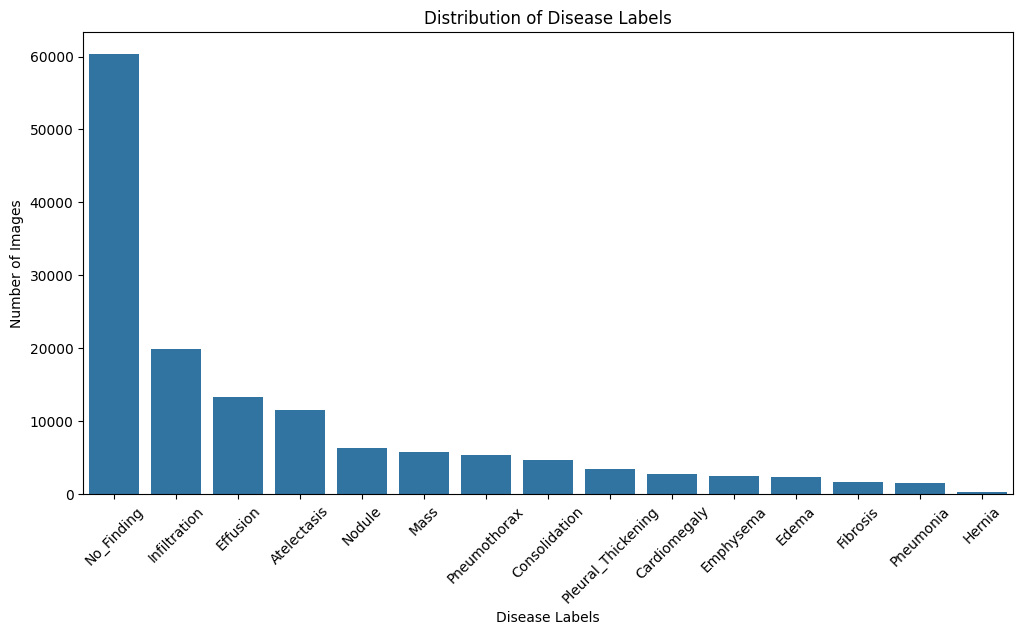

In [139]:
# Label Distribution
label_counts = labels_df[disease_labels + ['No_Finding']].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels")
plt.ylabel("Number of Images")
plt.xlabel("Disease Labels")
plt.show()

**Patient Gender Distribution**

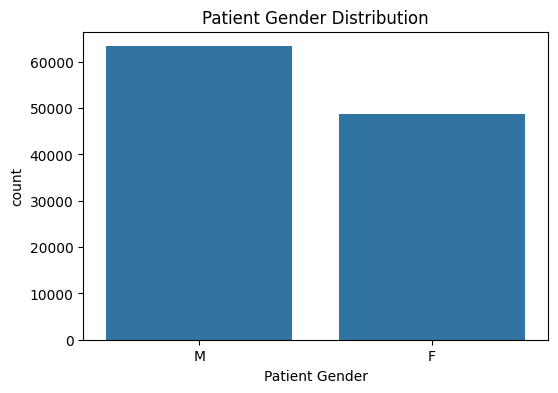

In [140]:
# Patient Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Gender', data=labels_df)
plt.title("Patient Gender Distribution")
plt.show()

**Patient Age Distribution**

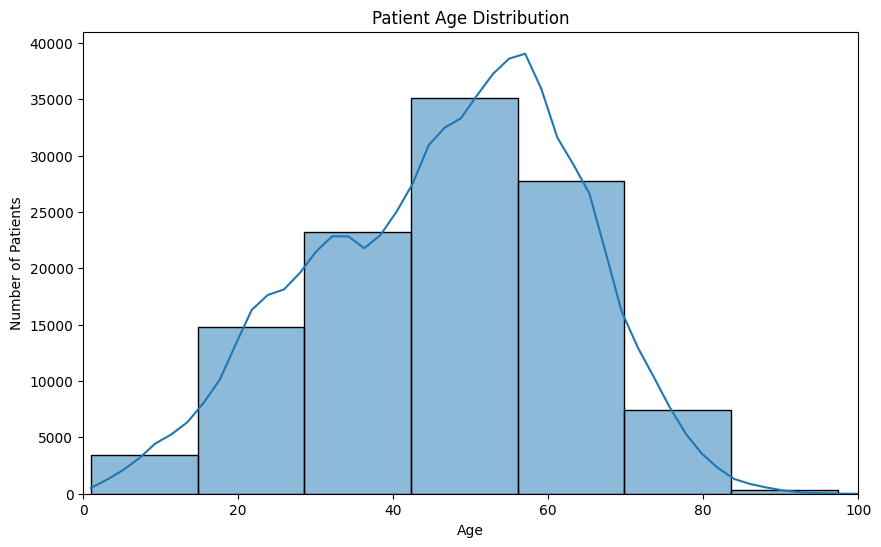

In [141]:
# Patient Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(labels_df['Patient Age'], bins=30, kde=True)
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.xlim(0, 100)
plt.show()

**View Position Distribution**

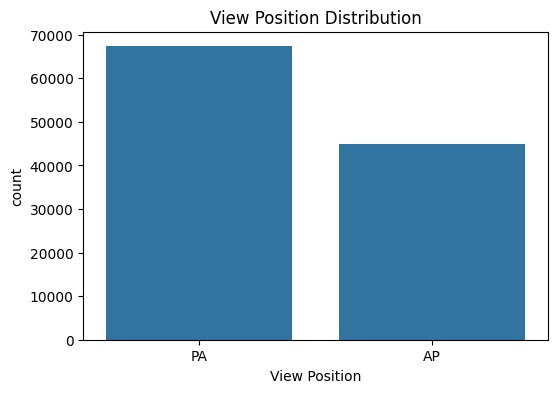

In [142]:
# View Position Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='View Position', data=labels_df)
plt.title("View Position Distribution")
plt.show()

**Correlation Matrix for Labels**

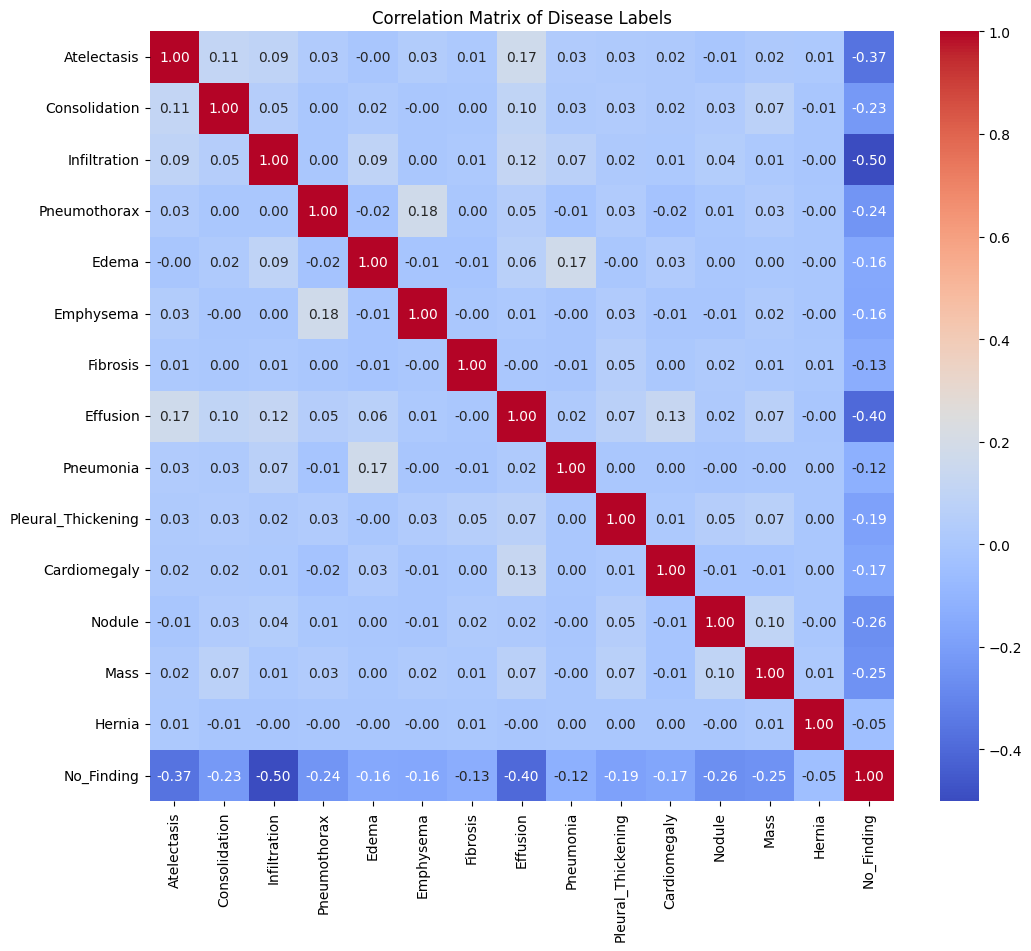

In [143]:
# Correlation Matrix for Labels
plt.figure(figsize=(12, 10))
sns.heatmap(labels_df[disease_labels + ['No_Finding']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Disease Labels")
plt.show()

# **Step 5: Split Dataset**

In [144]:
# Import FastAI Libraries
import fastai
from fastai.vision.all import *

In [145]:
# Get Unique Patient IDs
unique_patients = labels_df['Patient ID'].unique()

# Split Patients into Train+Val and Test (80-20)
train_val_patients, test_patients = train_test_split(
    unique_patients,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

# Create DataFrames
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


# **Step 6: Data Processing Part 2**

In [146]:
# Define datablock
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
    splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
    get_x=lambda row: row['Path'],
    get_y=lambda row: row[disease_labels].tolist(),
    item_tfms=[
        Resize((224, 224)),
    ],
    batch_tfms=[
        Flip(),
        Rotate(),
        Normalize.from_stats(*imagenet_stats),
    ]
)

# Create dataloader
dls = dblock.dataloaders(train_val_df, bs=128)

In [147]:
# Modify the final layer to match the number of classes in your dataset
num_classes = dls.c
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Define callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.0001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
]

# Create the Fastai Learner with the custom model
learn = vision_learner(
    dls,
    swin_v2_t,
    pretrained=True,
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],
    cbs=cbs,
    wd=0.001
)

# Wrap the model with DataParallel for multi-GPU training
learn.model = torch.nn.DataParallel(learn.model)

/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Step 7: Build the Model**

In [148]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

# **Step 8: Train the Model**

In [ ]:
class PrintBatchProgressCallback(Callback):
    def before_epoch(self):
        print(f"Starting epoch {self.epoch+1}/{self.n_epoch}")

    def before_batch(self):
        total_batches = len(self.dls.train)
        print(f"Processing batch {self.iter+1}/{total_batches} in epoch {self.epoch+1}/{self.n_epoch}", end="\r")

    def after_epoch(self):
        print(f"\nFinished epoch {self.epoch+1}/{self.n_epoch}")

# Use the callback while fine-tuning
learn.fine_tune(
    freeze_epochs=1, 
    epochs=0, 
    base_lr=lrs.valley, 
    cbs=[PrintBatchProgressCallback()]
)

# **Step 9: Evaluate the Model**

In [ ]:
# TODO